<h1><center>Named Entity Recognition Model using  Clinical BERT </center></h1>
<h4><center>Final Project W266</center></h4>


<h3><center>SUMMARY</center></h3>

In this notebook we will continue our implmentation of Medical Named Entity Recognition model using Scientific bert (see ["https://github.com/allenai/scibert"] 


`SciBERT` is a `BERT` model trained on scientific text.

* `SciBERT` is trained on papers from the corpus of [semanticscholar.org](https://semanticscholar.org). Corpus size is 1.14M papers, 3.1B tokens. We use the full text of the papers in training, not just abstracts.

* `SciBERT` has its own vocabulary (`scivocab`) that's built to best match the training corpus. We trained cased and uncased versions. We also include models trained on the original BERT vocabulary (`basevocab`) for comparison.

We look at the effect of also fine-tuning BERT layers which are pre-trained with clinical context. 


## II. Setup & Strategy

### II.1. Data<a id="data" />



In [1]:
!tail -20 'ner_dataset.csv'

",",",",O
M.D,NNP,O
JA25,NNP,O
Attending:,NNP,O
SYDNEY,NNP,O
DUESTERHAUS,NNP,O
",",",",O
M.D,NNP,O
MG85,NNP,O
EQ681/3978,NNP,O
Batch:,NNP,O
37609,CD,O
Index,NNP,O
No,NNP,O
FHOW8875S8,NNP,O
D:,NNP,O
6/10,CD,O
T:,NNP,O
1/22,CD,O
[report_end],NN,O


### II.2. Getting Started<a id="start" />

We start with some imports.

In [2]:
!pip install seqeval[gpu]

In [3]:
import warnings 
warnings.filterwarnings('ignore')
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
#import tensorflow_hub as hub
from time import time
import io
import re
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed

from sklearn.model_selection import train_test_split

from tqdm import tqdm, trange


from datetime import datetime
import os
import sys
import zipfile



In [4]:

# Define mddaximal length of input 'sentences' (post tokenization).
max_word = 40
max_length = 64

In [5]:

import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

Using TensorFlow backend.


In [6]:
MAX_LEN = 128
bs = 32

### Scientific bert Model 

#### Lets look at the model weights and the vocab file

In [7]:
print(os.listdir("/root"))
print(os.listdir("/root/biobert_pretrain_output_all_notes_150000"))


['All Models.ipynb', 'scibert_scivocab_cased', 'cuda-repo-ubuntu1604-10-1-local-10.1.168-418.67_1.0-1_amd64.deb', 'ner_tags', 'vocab.txt', 'biobert_pretrain_output_disch_100000', 'biobert_working-pytorch-gpu_v1.ipynb', '.gnupg', 'clibert.bin', 'sentence_boundaries.ipynb', 'all_bert_models-50.ipynb', 'validation_sentences.csv', 'Baseline_model.ipynb', 'biobert.bin', 'scibert-pytorch-gpu.ipynb', 'biobert_pretrain_output_all_notes_150000', 'clinicalbert.bin', 'attention_decoder.py', 'bert_config.json', 'cuda-repo-ubuntu1604-10-1-local-10.1.105-418.39_1.0-1_amd64.deb', 'clinicalbert-pytorch-gpu_notes.ipynb', 'validation_ner.csv', 'pytorch_model.bin', 'sentence_model.h5', '.profile', '.config', 'ner_dataset.csv', 'clinicalbert_working-pytorch-gpu_v1.ipynb', 'data', 'convert_to_pytorch_wt.ipynb', '.keras', '.nv', '.bash_history', 'eos.pyc', 'connengine.ipynb', 'answers', 'parser-bert.ipynb', 'bert_working-pytorch-gpu_v1.ipynb', '.pytorch_pretrained_bert', 'best_model.hdf5', 'config.json', '.

In [8]:
VOCAB = '/root/biobert_pretrain_output_all_notes_150000/vocab.txt'
MODEL = '/root/biobert_pretrain_output_all_notes_150000'

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [10]:
torch.cuda.get_device_name(0) 

'Tesla P100-PCIE-16GB'

## III. Data Preprocessing <a id="preprocess" />

### III.1 BERT Tokenizer<a id="tokenizer" />

We first start by defining and exploring the BERT tokenizer:

In [11]:
tokenizer = BertTokenizer.from_pretrained('/root/biobert_pretrain_output_disch_100000', do_lower_case=False)

In [12]:
# Tokenized input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)
print (tokenized_text)


['[CLS]', 'Who', 'was', 'Jim', 'He', '##nson', '?', '[SEP]', 'Jim', 'He', '##nson', 'was', 'a', 'puppet', '##eer', '[SEP]']


In [13]:
tokenizer.tokenize('I\'ll learn to swim in 12342 years.')

['I', "'", 'll', 'learn', 'to', 'swim', 'in', '123', '##42', 'years', '.']

Note how the "I'll" phrase and the number '12342' got split. This already highlights an area one needs to address: splitting of tokens will need to be accounted for in the labeling.

In [14]:
tokenizer.convert_tokens_to_ids(['I', "'", 'll', 'learn', 'to', 'swim', 'in', '123', '##42', 'years', '.'])

[146, 112, 1325, 3858, 1106, 11231, 1107, 13414, 23117, 1201, 119]

In [15]:
tokenizer.convert_ids_to_tokens([20958])

['Faye']

Good. Now we are ready to use it for our text.

### III.2. Extraction<a id="extract"/>


We have seen above how the data set looks. We can now turn to the pre-processing and creating the input for BERT. Specifically, we need to:

1) Tokenize the sentences. Note again that one word can be split into multiple tokens, and we need to insert custom labels when that happens to make sure we don't mess up the alignment. We choose a new 'nerX' label here.

2) Create BERT tokens and add [CLS], [PAD], etc.

3) Convert these tokens into ids, also via the tokenizer. These qill create the sentence_ids.

4) Create the mask ids. Mask out all of the padding tokens.

5) Create the sequence ids. In our case, they are all '0' as we do not compare or even have multiple sentences in one example.

To do this, we first define a helper function:

In [16]:
def addWord(word, pos, ner):
    """
    Convert a word into a word token and add supplied NER and POS labels. Note that the word can be  
    tokenized to two or more tokens. Correspondingly, we add - for now - custom 'X' tokens to the labels in order to 
    maintain the 1:1 mappings between word tokens and labels.
    
    arguments: word, pos label, ner label
    returns: dictionary with tokens and labels
    """
    # the dataset contains various '"""' combinations which we choose to truncate to '"', etc. 
    if word == '""""':
        word = '"'
    elif word == '``':
        word = '`'
        
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['posToken'] = [pos] + ['posX'] * (tokenLength - 1)
    addDict['nerToken'] = [ner] + ['nerX'] * (tokenLength - 1)
    addDict['tokenLength'] = list(str(tokenLength))
    
    
    return addDict


Let's see what it does:

In [17]:
addWord('protest', 'VB', 'O')

{'wordToken': ['protest'],
 'posToken': ['VB'],
 'nerToken': ['O'],
 'tokenLength': ['1']}

In [18]:
addWord('Iraq', 'NNP', 'B-geo')

{'wordToken': ['Iraq'],
 'posToken': ['NNP'],
 'nerToken': ['B-geo'],
 'tokenLength': ['1']}

In [19]:
addWord('10000', 'CD', 'O')

{'wordToken': ['1000', '##0'],
 'posToken': ['CD', 'posX'],
 'nerToken': ['O', 'nerX'],
 'tokenLength': ['2']}

We are now ready to convert the text file into appropriate arrays:

In [20]:
"""
Read the file line by line and construct sentences. A sentence end is marked by the word 'sentence' in the next row.
You need to take care of that. Also, you need to cap sentence length using max_length. Sentences which are shorter than 
max_length need to be padded. Also, we choose to end all sentences with a [SEP] token, padded or not. 
"""

with io.open('ner_dataset.csv', 'r', encoding='utf-8', errors='ignore') as train:
    text = train.readlines()


# lists for sentences, tokens, labels, etc.  
sentenceList = []
word_count = 0
sentenceTokenList = []
posTokenList = []
nerTokenList = []
sentLengthList = []
sentenceTokenLen = []
# lists for BERT input
bertSentenceIDs = []
bertMasks = []
bertSequenceIDs = []

sentence = ''

# always start with [CLS] tokens
sentenceTokens = ['[CLS]']
posTokens = ['[posCLS]']
nerTokens = ['[nerCLS]']
nerTokenLen = ['1']

for line in text:
    
    cleanLine = re.sub(r'(?!(([^"]*"){2})*[^"]*$),', '', line)  # deal with '"10,000"' and convert them to '10000' 

    word, pos, ner = cleanLine.split(',')
    
    ner = ner[:-1]   # remove DOS token
    
    # if new sentence starts
    if (word_count >= max_word -1):            
            
        sentenceLength = min(max_length -1, len(sentenceTokens))
        sentLengthList.append(sentenceLength)
        
                    
        # Create space for at least a final '[SEP]' token
        if sentenceLength >= max_length - 1: 
            sentenceTokens = sentenceTokens[:max_length - 2]
            posTokens = posTokens[:max_length - 2]
            nerTokens = nerTokens[:max_length - 2]

        # add a ['SEP'] token and padding
        
        sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length -1 - len(sentenceTokens))
        
        posTokens += ['[posSEP]'] + ['[posPAD]'] * (max_length - 1 - len(posTokens) )
        nerTokens += ['[nerSEP]'] + ['[nerPAD]'] * (max_length - 1 - len(nerTokens) )
            
        sentenceList.append(sentence)

        sentenceTokenList.append(sentenceTokens)
        
        sentenceTokenLen.append(nerTokenLen)

        bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
        bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length -1 - sentenceLength ))
        bertSequenceIDs.append([0] * (max_length))
                             
        posTokenList.append(posTokens)
        nerTokenList.append(nerTokens)
        
        sentence = ''
        sentenceTokens = ['[CLS]']
        posTokens = ['[posCLS]']
        nerTokens = ['[nerCLS]']
        
        sentence += ' ' + word
        word_count = 0
    
    word_count += 1
    addDict = addWord(word, pos, ner)

    sentenceTokens += addDict['wordToken']
    posTokens += addDict['posToken']
    nerTokens += addDict['nerToken']
    nerTokenLen += addDict['tokenLength']
# The first two list elements need to be removed. 1st line in file is a-typical, and 2nd line does not end a sentence   
sentLengthList = sentLengthList[2:]
sentenceTokenList = sentenceTokenList[2:]
bertSentenceIDs = bertSentenceIDs[2:]
bertMasks = bertMasks[2:]
bertSequenceIDs = bertSequenceIDs[2:]
posTokenList = posTokenList[2:]
nerTokenList = nerTokenList[2:]
nerTokenLen = nerTokenLen[2:]

What did this do?

In [21]:
print(nerTokenLen[4])

5


In [22]:
print(sentLengthList[4])

47


In [23]:
print(bertSentenceIDs[4])

[101, 2103, 1115, 1123, 2555, 1125, 1151, 2221, 107, 107, 1105, 1175, 1127, 1185, 2091, 8661, 2879, 1895, 27631, 13066, 1224, 1608, 1109, 5884, 1104, 27631, 20702, 1166, 1103, 1736, 1104, 1103, 1480, 107, 107, 1170, 1134, 1553, 1131, 1108, 2752, 1171, 1106, 2001, 10805, 8643, 3875, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [24]:
print(sentenceTokenList[4])

['[CLS]', 'reported', 'that', 'her', 'foot', 'had', 'been', 'blue', '"', '"', 'and', 'there', 'were', 'no', 'Do', '##pp', '##ler', '##able', 'pulses', 'Color', 'later', 'returned', 'The', 'absence', 'of', 'pulses', 'persisted', 'over', 'the', 'course', 'of', 'the', 'night', '"', '"', 'after', 'which', 'point', 'she', 'was', 'referred', 'back', 'to', 'La', '##rg', '##rine', 'Medical', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [25]:
print(nerTokenList[4])

['[nerCLS]', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'nerX', 'O', 'O', 'O', 'O', 'O', 'nerX', 'nerX', 'nerX', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'nerX', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'nerX', 'nerX', 'O', '[nerSEP]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]']


In [26]:
print(bertMasks[4])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


This looks right. Everything past the '[SEP]' token, i.e., the '[nerSEP]' label, is masked out. Also the sequence_ids are correct: there is only one sentence, so all ids should have the same value of zero.

In [27]:
print(bertSequenceIDs[4])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Looks reasonable. 


### III.3. Initial Data Analysis<a id="analysis" />

It is important to understand the dataset prior to doing any modeling or training. First, what are the length of the original sentences.

(array([   5.,    0.,    7.,    0.,    0.,   21.,    0.,    0.,   31.,
           0.,   44.,    0.,    0.,   51.,    0.,    0.,   69.,    0.,
          85.,    0.,    0.,  108.,    0.,    0.,  128.,    0.,  149.,
           0.,    0.,  163.,    0.,    0.,  169.,    0.,    0.,  178.,
           0.,  201.,    0.,    0.,  208.,    0.,    0.,  228.,    0.,
         228.,    0.,    0.,  224.,    0.,    0.,  222.,    0.,  192.,
           0.,    0.,  179.,    0.,    0.,  186.,    0., 4412.]),
 array([40.        , 40.37096774, 40.74193548, 41.11290323, 41.48387097,
        41.85483871, 42.22580645, 42.59677419, 42.96774194, 43.33870968,
        43.70967742, 44.08064516, 44.4516129 , 44.82258065, 45.19354839,
        45.56451613, 45.93548387, 46.30645161, 46.67741935, 47.0483871 ,
        47.41935484, 47.79032258, 48.16129032, 48.53225806, 48.90322581,
        49.27419355, 49.64516129, 50.01612903, 50.38709677, 50.75806452,
        51.12903226, 51.5       , 51.87096774, 52.24193548, 52.6129032

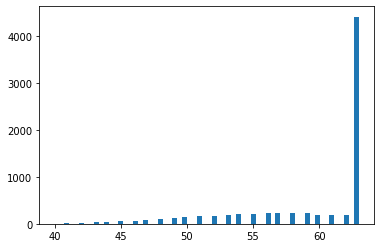

In [28]:
sentenceLengths= [l for l in sentLengthList]

plt.hist(np.array(sentenceLengths), bins=(max_length-2))

In [29]:
numSentences = len(bertSentenceIDs)

nerClasses = pd.DataFrame(np.array(nerTokenList).reshape(-1))
nerClasses.columns = ['tag']
nerClasses.tag = pd.Categorical(nerClasses.tag)
nerClasses['cat'] = nerClasses.tag.cat.codes
nerClasses['sym'] = nerClasses.tag.cat.codes
nerLabels = np.array(nerClasses.cat).reshape(numSentences, -1) 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbc0e63b390>]],
      dtype=object)

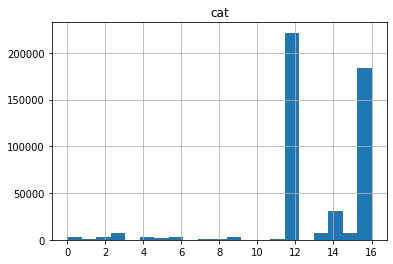

In [30]:
nerClasses[['cat']].hist(bins=21)

Looks like a lot of tables with value 12+

In [31]:
nerDistribution = (nerClasses.groupby(['tag', 'cat']).agg({'sym':'count'}).reset_index()
                   .rename(columns={'sym':'occurences'}))

numNerClasses = nerDistribution.tag.nunique()

nerDistribution

,tag,cat,occurences
0,B-do,0,3520
1,B-du,1,485
2,B-f,2,3171
3,B-m,3,7443
4,B-mo,4,2664
5,B-r,5,1479
6,I-do,6,3146
7,I-du,7,1020
8,I-f,8,1109
9,I-m,9,3321


In [32]:
nerDistribution1 = nerDistribution[['tag', 'cat']]

nerDistribution1.to_csv('ner_tags', sep='\t', index=False, header=False)



### III.4. Baseline: Always picking 'Other'<a id="baseline" />

Let's see what a baseline would give for the actual text tokens, if I ALWAYS chose the most common token 'O':

In [33]:
O_occurences = nerDistribution.loc[nerDistribution.tag == 'O','occurences']
All_occurences = nerDistribution[nerDistribution.cat < 13]['occurences'].sum()

O_occurences/All_occurences

12    0.885908
Name: occurences, dtype: float64

So **88.5%** is the baseline

### III.5. Train/Test Split and Final Data Preparation<a id="split" />

In the last step we need to prepare both labels and input for the model, including the train/test split.

In [34]:
bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])



In [35]:
tr_inputs, val_inputs, tr_tags, val_tags, tr_sen, val_sen, tr_ner, val_ner = train_test_split(bertSentenceIDs, 
                                                                                              nerLabels,sentenceTokenList, 
                                                            nerTokenList,random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(bertMasks, bertSentenceIDs,
                                             random_state=2018, test_size=0.1)

In [36]:
print(tr_masks[6])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [37]:
print(tr_inputs[6])

[101, 1132, 15498, 125, 5135, 13335, 8643, 131, 1109, 5351, 1144, 170, 1607, 1104, 17972, 17972, 1335, 1148, 107, 107, 1119, 1108, 1113, 1117, 1313, 13753, 1104, 151, 2101, 3048, 26825, 1134, 1108, 1406, 2338, 4841, 12734, 13064, 3828, 1112, 1218, 1112, 1126, 26825, 7989, 3418, 2279, 1104, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [38]:
tr_tags[6]

array([13, 12, 12, 12, 12, 16, 16, 16, 12, 12, 12, 12, 12, 12,  5,  5, 12,
       12, 12, 16, 12, 12, 12, 12, 12, 12, 12,  3, 16, 16,  9, 12, 12,  0,
        6,  4, 16, 16,  2, 12, 12, 12, 12,  3,  0,  6, 12, 12, 15, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14], dtype=int8)

In [39]:
print(sentenceTokenList[6])

['[CLS]', 'on', 'the', '2', 'of', 'September', 'PA', '##ST', 'S', '##UR', '##GI', '##CA', '##L', 'H', '##IS', '##TO', '##R', '##Y', ':', 'Notable', 'for', 'the', 'above', '"', '"', 'as', 'well', 'as', 'de', '##bri', '##de', '##ments', 'of', 'her', 'toe', 'am', '##putation', 'wound', 'site', 'AD', '##MI', '##SS', '##ION', 'ME', '##DI', '##CA', '##TI', '##ON', '##S', ':', 'Cola', '##ce', '100', 'mg', 'b', '.', 'i', '.', 'd', '"', '"', 'insulin', '[SEP]', '[PAD]']


In [40]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags, dtype=torch.long, device=device)
val_tags = torch.tensor(val_tags, dtype=torch.long, device=device)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [41]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [42]:
#config = BertConfig.from_json_file('/root/biobert_v1.0_pubmed_pmc/bert_config.json')
model = BertForTokenClassification.from_pretrained('/root/biobert_pretrain_output_all_notes_150000', num_labels=nerDistribution['tag'].count())
#model = BertForTokenClassification.from_pretrained("scibert-basevocab-cased", num_labels=len(tag2idx))

In [43]:
print(model)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementw

In [44]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=9e-6)

In [45]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementw

In [46]:
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report, accuracy_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [47]:
epochs = 50
max_grad_norm = 1.0

train_loss = []
evaluation_loss = []
f1score = []
for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    train_loss.append(tr_loss/nb_tr_steps)
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    evaluation_loss.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == p_i).idxmax()][0] for p in predictions for p_i in p])
    valid_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][0] for l in true_labels for l_i in l for l_ii in l_i])
    valid_ids = [nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][1] for l in true_labels for l_i in l for l_ii in l_i]
    mask = (np.array(valid_ids) < 13)
    #print(mask)
    pred = np.ma.compressed(np.ma.MaskedArray(pred_tags, mask=~mask))
    valid = np.ma.compressed(np.ma.MaskedArray(valid_tags, mask=~mask))
    #print(pred.tolist())
    print("F1-Score: {}".format(f1_score(pred.tolist(), valid.tolist())))
    f1score.append(f1_score(pred.tolist(), valid.tolist()))
    print("Recall: {}".format(recall_score(pred.tolist(), valid.tolist())))
    

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.5329372774438835
Validation loss: 0.1116071396196882
Validation Accuracy: 0.9505364833733975


Epoch:   2%|▏         | 1/50 [02:39<2:10:15, 159.51s/it]

F1-Score: 0.6829527349973447
Recall: 0.6732984293193718
Train loss: 0.09884966984038104
Validation loss: 0.07049883032838504
Validation Accuracy: 0.9623960837339743


Epoch:   4%|▍         | 2/50 [05:18<2:07:29, 159.36s/it]

F1-Score: 0.8015936254980081
Recall: 0.7904662126767942
Train loss: 0.06837365868108533
Validation loss: 0.059890006513645254
Validation Accuracy: 0.9653038611778846


Epoch:   6%|▌         | 3/50 [07:57<2:04:45, 159.26s/it]

F1-Score: 0.8160123171670516
Recall: 0.7790298873101421
Train loss: 0.05454288859149856
Validation loss: 0.05418618357119461
Validation Accuracy: 0.9688094701522436


Epoch:   8%|▊         | 4/50 [10:36<2:01:55, 159.04s/it]

F1-Score: 0.8351933558266287
Recall: 0.8057085628442664
Train loss: 0.04594379069363054
Validation loss: 0.05256184213794768
Validation Accuracy: 0.9675793770032052


Epoch:  10%|█         | 5/50 [13:14<1:59:11, 158.93s/it]

F1-Score: 0.8386765837394203
Recall: 0.8002936857562408
Train loss: 0.039504831912816986
Validation loss: 0.049474261701107025
Validation Accuracy: 0.9684150891426282


Epoch:  12%|█▏        | 6/50 [15:52<1:56:22, 158.69s/it]

F1-Score: 0.8468328141225338
Recall: 0.8171342685370742
Train loss: 0.0346392253722766
Validation loss: 0.04734084623244902
Validation Accuracy: 0.9724105443709936


Epoch:  14%|█▍        | 7/50 [18:31<1:53:36, 158.53s/it]

F1-Score: 0.8527334554015171
Recall: 0.8286731062531775
Train loss: 0.03019396778001887
Validation loss: 0.04891204841745397
Validation Accuracy: 0.9728096203926282


Epoch:  16%|█▌        | 8/50 [21:09<1:50:55, 158.46s/it]

F1-Score: 0.8531073446327683
Recall: 0.8150147203140333
Train loss: 0.026362630880715863
Validation loss: 0.048070016239459314
Validation Accuracy: 0.9742118639823718


Epoch:  18%|█▊        | 9/50 [23:48<1:48:25, 158.67s/it]

F1-Score: 0.8574380165289255
Recall: 0.8234126984126984
Train loss: 0.023357025744896648
Validation loss: 0.04997502360492945
Validation Accuracy: 0.9765797150440706


Epoch:  20%|██        | 10/50 [26:27<1:45:53, 158.83s/it]

F1-Score: 0.873328088119591
Recall: 0.8507920286152274
Train loss: 0.02030710187206548
Validation loss: 0.05142081071001788
Validation Accuracy: 0.976276104266827


Epoch:  22%|██▏       | 11/50 [29:07<1:43:20, 158.98s/it]

F1-Score: 0.861219195849546
Recall: 0.8304152076038019
Train loss: 0.01794143325110712
Validation loss: 0.055139682022854686
Validation Accuracy: 0.975246331630609


Epoch:  24%|██▍       | 12/50 [31:46<1:40:44, 159.07s/it]

F1-Score: 0.875629806417396
Recall: 0.8621409921671018
Train loss: 0.01649444164284527
Validation loss: 0.05188576062209904
Validation Accuracy: 0.9770273061899039


Epoch:  26%|██▌       | 13/50 [34:25<1:38:08, 159.14s/it]

F1-Score: 0.8644593895499224
Recall: 0.8313432835820895
Train loss: 0.014539752973208283
Validation loss: 0.054147288436070085
Validation Accuracy: 0.9786830804286858


Epoch:  28%|██▊       | 14/50 [37:04<1:35:20, 158.92s/it]

F1-Score: 0.8635416666666665
Recall: 0.8356854838709677
Train loss: 0.012658921242537091
Validation loss: 0.05855422195357581
Validation Accuracy: 0.9785109299879808


Epoch:  30%|███       | 15/50 [39:42<1:32:37, 158.77s/it]

F1-Score: 0.8620689655172414
Recall: 0.8251231527093597
Train loss: 0.011266474188327507
Validation loss: 0.059544629883021116
Validation Accuracy: 0.9791416266025642


Epoch:  32%|███▏      | 16/50 [42:20<1:29:53, 158.64s/it]

F1-Score: 0.8575891694871128
Recall: 0.8297229219143577
Train loss: 0.010129194938957304
Validation loss: 0.0640675153893729
Validation Accuracy: 0.979823968349359


Epoch:  34%|███▍      | 17/50 [45:00<1:27:23, 158.88s/it]

F1-Score: 0.8613554061045008
Recall: 0.8283582089552238
Train loss: 0.00915669287517402
Validation loss: 0.0652083073121806
Validation Accuracy: 0.9793043870192308


Epoch:  36%|███▌      | 18/50 [47:39<1:24:45, 158.93s/it]

F1-Score: 0.8636363636363636
Recall: 0.8382352941176471
Train loss: 0.008354635824233082
Validation loss: 0.06419836450368166
Validation Accuracy: 0.980537610176282


Epoch:  38%|███▊      | 19/50 [50:18<1:22:10, 159.04s/it]

F1-Score: 0.8636481241914618
Recall: 0.8307615729218517
Train loss: 0.007592006550629522
Validation loss: 0.0679460046812892
Validation Accuracy: 0.9814813075921475


Epoch:  40%|████      | 20/50 [52:57<1:19:27, 158.92s/it]

F1-Score: 0.8673173305196518
Recall: 0.8496124031007752
Train loss: 0.007049274866158028
Validation loss: 0.06730370875447989
Validation Accuracy: 0.9813592372796475


Epoch:  42%|████▏     | 21/50 [55:36<1:16:47, 158.88s/it]

F1-Score: 0.8674192701496457
Recall: 0.8458781362007168
Train loss: 0.006204256152853334
Validation loss: 0.06880783281909923
Validation Accuracy: 0.9805329151642628


Epoch:  44%|████▍     | 22/50 [58:14<1:14:02, 158.67s/it]

F1-Score: 0.8647519582245431
Recall: 0.8389057750759878
Train loss: 0.006173072955229042
Validation loss: 0.06887704211597641
Validation Accuracy: 0.9798036232972757


Epoch:  46%|████▌     | 23/50 [1:00:53<1:11:29, 158.85s/it]

F1-Score: 0.8606344253770151
Recall: 0.8316582914572864
Train loss: 0.005243332839049002
Validation loss: 0.0672803920848916
Validation Accuracy: 0.979038336338141


Epoch:  48%|████▊     | 24/50 [1:03:32<1:08:53, 158.97s/it]

F1-Score: 0.8622881355932204
Recall: 0.8479166666666667
Train loss: 0.00501765433014194
Validation loss: 0.06883403775282204
Validation Accuracy: 0.9808490459735576


Epoch:  50%|█████     | 25/50 [1:06:11<1:06:16, 159.05s/it]

F1-Score: 0.861643475977947
Recall: 0.8402457757296466
Train loss: 0.004487394028198707
Validation loss: 0.0724570363915215
Validation Accuracy: 0.9810728415464743


Epoch:  52%|█████▏    | 26/50 [1:08:51<1:03:37, 159.07s/it]

F1-Score: 0.8692690594707886
Recall: 0.845996940336563
Train loss: 0.004309551234487267
Validation loss: 0.07283997784058253
Validation Accuracy: 0.9773418719951924


Epoch:  54%|█████▍    | 27/50 [1:11:30<1:01:00, 159.15s/it]

F1-Score: 0.8602428313097391
Recall: 0.826302729528536
Train loss: 0.004031962398671373
Validation loss: 0.07425153053676088
Validation Accuracy: 0.9795688726963142


Epoch:  56%|█████▌    | 28/50 [1:14:08<58:15, 158.91s/it]  

F1-Score: 0.869496440812022
Recall: 0.8513164687661332
Train loss: 0.003505277926719116
Validation loss: 0.07874281797558069
Validation Accuracy: 0.9791118915264424


Epoch:  58%|█████▊    | 29/50 [1:16:47<55:33, 158.74s/it]

F1-Score: 0.858179932590096
Recall: 0.8270864567716142
Train loss: 0.0035633877714515458
Validation loss: 0.07909134263172746
Validation Accuracy: 0.9795688726963142


Epoch:  60%|██████    | 30/50 [1:19:25<52:50, 158.52s/it]

F1-Score: 0.868062827225131
Recall: 0.8441955193482689
Train loss: 0.0030035309316160078
Validation loss: 0.07759743416681886
Validation Accuracy: 0.977260491786859


Epoch:  62%|██████▏   | 31/50 [1:22:03<50:11, 158.47s/it]

F1-Score: 0.8656795346377578
Recall: 0.8499480789200415
Train loss: 0.0029272693854875825
Validation loss: 0.07946492351281147
Validation Accuracy: 0.9795579176682692


Epoch:  64%|██████▍   | 32/50 [1:24:41<47:30, 158.34s/it]

F1-Score: 0.8695884553714591
Recall: 0.8626723223753977
Train loss: 0.002999891318856425
Validation loss: 0.07923977527146538
Validation Accuracy: 0.9797222430889424


Epoch:  66%|██████▌   | 33/50 [1:27:19<44:51, 158.33s/it]

F1-Score: 0.8538860103626943
Recall: 0.8223552894211577
Train loss: 0.0024182535496223676
Validation loss: 0.0847116019576788
Validation Accuracy: 0.9811041416266025


Epoch:  68%|██████▊   | 34/50 [1:29:58<42:13, 158.32s/it]

F1-Score: 0.8655529037390612
Recall: 0.852219321148825
Train loss: 0.00228179884526627
Validation loss: 0.08347428791845839
Validation Accuracy: 0.980049328926282


Epoch:  70%|███████   | 35/50 [1:32:36<39:34, 158.31s/it]

F1-Score: 0.8669640514300708
Recall: 0.8450127877237852
Train loss: 0.0022516386007991624
Validation loss: 0.08217262911299865
Validation Accuracy: 0.9795375726161858


Epoch:  72%|███████▏  | 36/50 [1:35:15<36:58, 158.49s/it]

F1-Score: 0.8697478991596639
Recall: 0.8483606557377049
Train loss: 0.002359837469627189
Validation loss: 0.07905345348020394
Validation Accuracy: 0.9779522235576924


Epoch:  74%|███████▍  | 37/50 [1:37:53<34:18, 158.37s/it]

F1-Score: 0.8575122834238429
Recall: 0.8244654400795625
Train loss: 0.0020406514329513563
Validation loss: 0.08167463603119056
Validation Accuracy: 0.9767847305689102


Epoch:  76%|███████▌  | 38/50 [1:40:32<31:44, 158.67s/it]

F1-Score: 0.8677664310028803
Recall: 0.8441161487519103
Train loss: 0.0018541450543694367
Validation loss: 0.08749524612600605
Validation Accuracy: 0.9770977313701924


Epoch:  78%|███████▊  | 39/50 [1:43:12<29:08, 158.95s/it]

F1-Score: 0.872948650079407
Recall: 0.8579604578563996
Train loss: 0.0018289561203216926
Validation loss: 0.08763675546894471
Validation Accuracy: 0.9782996544471154


Epoch:  80%|████████  | 40/50 [1:45:51<26:31, 159.11s/it]

F1-Score: 0.8634361233480178
Recall: 0.8317523714428358
Train loss: 0.0017373467408235393
Validation loss: 0.08575857756659389
Validation Accuracy: 0.9781744541266025


Epoch:  82%|████████▏ | 41/50 [1:48:31<23:53, 159.26s/it]

F1-Score: 0.8755980861244018
Recall: 0.8641133263378804
Train loss: 0.0016445162583247899
Validation loss: 0.08671434448721509
Validation Accuracy: 0.9770883413461539


Epoch:  84%|████████▍ | 42/50 [1:51:11<21:15, 159.38s/it]

F1-Score: 0.8628168278024563
Recall: 0.8376458650431253
Train loss: 0.0014467673286960032
Validation loss: 0.08961654625212152
Validation Accuracy: 0.9765906700721154


Epoch:  86%|████████▌ | 43/50 [1:53:49<18:32, 158.97s/it]

F1-Score: 0.873157894736842
Recall: 0.8533950617283951
Train loss: 0.0016822764504537035
Validation loss: 0.08432206899548571
Validation Accuracy: 0.976143078926282


Epoch:  88%|████████▊ | 44/50 [1:56:27<15:52, 158.82s/it]

F1-Score: 0.868766404199475
Recall: 0.8469805527123848
Train loss: 0.0014121919064745319
Validation loss: 0.09031143179163337
Validation Accuracy: 0.9754513471554488


Epoch:  90%|█████████ | 45/50 [1:59:05<13:13, 158.69s/it]

F1-Score: 0.8684967320261439
Recall: 0.8435754189944135
Train loss: 0.0012746002519297992
Validation loss: 0.09288939973339438
Validation Accuracy: 0.9780429937900642


Epoch:  92%|█████████▏| 46/50 [2:01:45<10:35, 158.85s/it]

F1-Score: 0.8634338138925295
Recall: 0.8407350689127105
Train loss: 0.0013531302073978714
Validation loss: 0.08669297971452276
Validation Accuracy: 0.9792543068910257


Epoch:  94%|█████████▍| 47/50 [2:04:24<07:57, 159.04s/it]

F1-Score: 0.8723516949152542
Recall: 0.8578125
Train loss: 0.0010897871806354966
Validation loss: 0.08846070291474462
Validation Accuracy: 0.9785531850961539


Epoch:  96%|█████████▌| 48/50 [2:07:03<05:18, 159.01s/it]

F1-Score: 0.8659630606860158
Recall: 0.8485005170630817
Train loss: 0.0010064974864746191
Validation loss: 0.09497794120882948
Validation Accuracy: 0.9788990509815706


Epoch:  98%|█████████▊| 49/50 [2:09:42<02:39, 159.06s/it]

F1-Score: 0.8696109358569927
Recall: 0.8490759753593429
Train loss: 0.0009334777936411655
Validation loss: 0.09345860189447801
Validation Accuracy: 0.9781181139823718


Epoch: 100%|██████████| 50/50 [2:12:21<00:00, 159.05s/it]

F1-Score: 0.8693834900731452
Recall: 0.8438133874239351


In [48]:
!pip install scipy

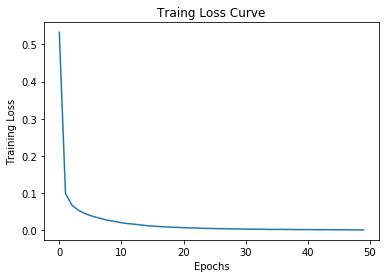

In [49]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Traing Loss Curve")
plt.show()

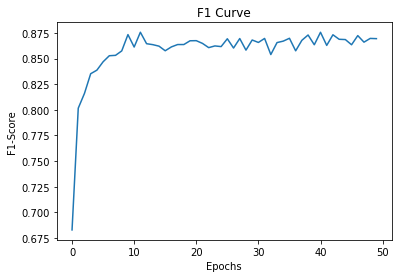

In [50]:

import matplotlib.pyplot as plt

plt.plot(f1score)
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.title("F1 Curve")
plt.show()


In [51]:
import csv 

with open('sentences.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(sentenceTokenList)

In [52]:
with open('ner.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(nerTokenList)

In [53]:
with open('validation_sentences.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(val_sen)

In [54]:
with open('validation_ner.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(val_ner)

In [55]:
with open('validation_pred_ner.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(pred_tags)

In [56]:
model1 = BertForTokenClassification.from_pretrained('/root/biobert_pretrain_output_all_notes_150000', num_labels=nerDistribution['tag'].count())
#model = BertForTokenClassification.from_pretrained("scibert-basevocab-cased", num_labels=len(tag2idx))

In [57]:
import re

regexp = re.compile(r'layer\.[0-7]\.')
for name, param in model1.named_parameters():                
    #print (name,regexp.search(name) )
    if regexp.search(name):
        #print(name)
        param.requires_grad = False

In [58]:
model1.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementw

In [59]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=2e-4)

In [60]:
epochs = 15
max_grad_norm = 1.0

for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model1.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model1(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model1.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model1.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    # VALIDATION on validation set
    model1.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model1(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model1(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == p_i).idxmax()][0] for p in predictions for p_i in p])
    valid_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][0] for l in true_labels for l_i in l for l_ii in l_i])
    valid_ids = [nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][1] for l in true_labels for l_i in l for l_ii in l_i]
    mask = (np.array(valid_ids) < 13)
    #print(mask)
    pred = np.ma.compressed(np.ma.MaskedArray(pred_tags, mask=~mask))
    valid = np.ma.compressed(np.ma.MaskedArray(valid_tags, mask=~mask))
    #print(pred.tolist())
    print("F1-Score: {}".format(f1_score(pred.tolist(), valid.tolist())))
    print("Recall: {}".format(recall_score(pred.tolist(), valid.tolist())))
    

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 2.861893290027058
Validation loss: 2.8695632417996726
Validation Accuracy: 0.06788674379006411


Epoch:   7%|▋         | 1/15 [02:30<35:06, 150.44s/it]

F1-Score: 0.005109006826690157
Recall: 0.0027819080051801046
Train loss: 2.861677095223377
Validation loss: 2.8695632417996726
Validation Accuracy: 0.06788674379006411


Epoch:  13%|█▎        | 2/15 [05:01<32:36, 150.50s/it]

F1-Score: 0.005109006826690157
Recall: 0.0027819080051801046
Train loss: 2.8616827562521983
Validation loss: 2.8695632417996726
Validation Accuracy: 0.06788674379006411


Epoch:  20%|██        | 3/15 [07:31<30:05, 150.50s/it]

F1-Score: 0.005109006826690157
Recall: 0.0027819080051801046
Train loss: 2.861751904419813
Validation loss: 2.8695632417996726
Validation Accuracy: 0.06788674379006411


Epoch:  27%|██▋       | 4/15 [10:01<27:34, 150.40s/it]

F1-Score: 0.005109006826690157
Recall: 0.0027819080051801046
Train loss: 2.8616034329220015
Validation loss: 2.8695632417996726
Validation Accuracy: 0.06788674379006411


Epoch:  33%|███▎      | 5/15 [12:31<25:00, 150.07s/it]

F1-Score: 0.005109006826690157
Recall: 0.0027819080051801046
Train loss: 2.861428565888608
Validation loss: 2.8695632417996726
Validation Accuracy: 0.06788674379006411


Epoch:  40%|████      | 6/15 [15:01<22:31, 150.15s/it]

F1-Score: 0.005109006826690157
Recall: 0.0027819080051801046
Train loss: 2.861783991492755
Validation loss: 2.8695632417996726
Validation Accuracy: 0.06788674379006411


Epoch:  47%|████▋     | 7/15 [17:31<20:01, 150.22s/it]

F1-Score: 0.005109006826690157
Recall: 0.0027819080051801046
Train loss: 2.861643307581897
Validation loss: 2.8695632417996726
Validation Accuracy: 0.06788674379006411


Epoch:  53%|█████▎    | 8/15 [20:01<17:30, 150.01s/it]

F1-Score: 0.005109006826690157
Recall: 0.0027819080051801046
Train loss: 2.861455733177221
Validation loss: 2.8695632417996726
Validation Accuracy: 0.06788674379006411


Epoch:  60%|██████    | 9/15 [22:31<14:59, 149.95s/it]

F1-Score: 0.005109006826690157
Recall: 0.0027819080051801046
Train loss: 2.8614733049654846
Validation loss: 2.8695632417996726
Validation Accuracy: 0.06788674379006411


Epoch:  67%|██████▋   | 10/15 [25:02<12:31, 150.24s/it]

F1-Score: 0.005109006826690157
Recall: 0.0027819080051801046
Train loss: 2.862215961890198
Validation loss: 2.8695632417996726
Validation Accuracy: 0.06788674379006411


Epoch:  73%|███████▎  | 11/15 [27:31<10:00, 150.02s/it]

F1-Score: 0.005109006826690157
Recall: 0.0027819080051801046
Train loss: 2.862082519802437
Validation loss: 2.8695632417996726
Validation Accuracy: 0.06788674379006411


Epoch:  80%|████████  | 12/15 [30:01<07:30, 150.08s/it]

F1-Score: 0.005109006826690157
Recall: 0.0027819080051801046
Train loss: 2.861621467988073
Validation loss: 2.8695632417996726
Validation Accuracy: 0.06788674379006411


Epoch:  87%|████████▋ | 13/15 [32:32<05:00, 150.15s/it]

F1-Score: 0.005109006826690157
Recall: 0.0027819080051801046
Train loss: 2.861316069607486
Validation loss: 2.8695632417996726
Validation Accuracy: 0.06788674379006411


Epoch:  93%|█████████▎| 14/15 [35:02<02:30, 150.15s/it]

F1-Score: 0.005109006826690157
Recall: 0.0027819080051801046
Train loss: 2.8615032846893746
Validation loss: 2.8695632417996726
Validation Accuracy: 0.06788674379006411


Epoch: 100%|██████████| 15/15 [37:33<00:00, 150.36s/it]

F1-Score: 0.005109006826690157
Recall: 0.0027819080051801046
